In [8]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np


In [9]:
def v2z(v, zo, vp, vzero=0):
    """Convert a voltage waveform to an impedance.
    v => voltage array (one-dimensional numpy.ndarray)
    zo => the reference impedance
    vp => initial pulse height (might also be called v50ohm)
    vzero => zero voltage that may not be exactly zero -- subtract from the
        voltage step to get the true height of the step.
    """
    v_ = np.array(v)
    vp0 = vp - vzero
    v0 = v_-vzero
    return zo * v0 / (2*vp0 - v0)


In [10]:
# Time delay for each transmission line segment
td = 50e-12

# Propagation velocity in cm/s
vp = 3e10/np.sqrt(3.5)

# Physical length of each transmission line segment.
lx = vp*td

# Length of the line to analyze ... Use this to adjust the length of the plots below.
Ltot = 50 # cm

# Lumped series resistance (per transmission line segment)
rloss_pul = 0.01 # Ohm/cm
Rloss = rloss_pul*lx
print("Rloss per segment = %.3g" % Rloss)

# Characteristic impedance of the line
Zo = 50

# Amplitude of the RGW.
Vplus = 1.0

# The reflection coefficient at a lumped resistor location in either direction is given by ...
G = Rloss / (Rloss + 2*Zo) 
print("G = %.3g" % G)

# The transmission coefficient at a lumped resistor location in either direction is given by ...
T = 2*Zo / (Rloss + 2*Zo)
print("T = %.3g" % T)

# Conversions from time to distance and the reverse (for TDR measurements)
t2l = lambda t_ : vp * t_/1e9/2.0
l2t = lambda l_ : l_/vp * 2.0 * 1e9


Rloss per segment = 0.00802
G = 8.02e-05
T = 1


# Track All Reflections (Including Multiple Reflections)

Track all reflections and multiple reflections through 6 steps.  Note that each step in my vector below is actually two $t_d$, because it takes that long for the wave to propagation down and back from anyone one segment.

<img src="figs/Full_Bounce_Diagram_Series_Resistance.png" alt="Bounce Full" width="50%"/>

[1.00000000e+00 8.01719445e-05 8.01590900e-05 8.01462380e-05
 8.01333891e-05 8.01205422e-05]
[1.0, 1.0000801719445176, 1.000160331034469, 1.000240477272431, 1.000320610661494, 1.0004007312037178]


Text(0.5, 0, 'Distance (cm)')

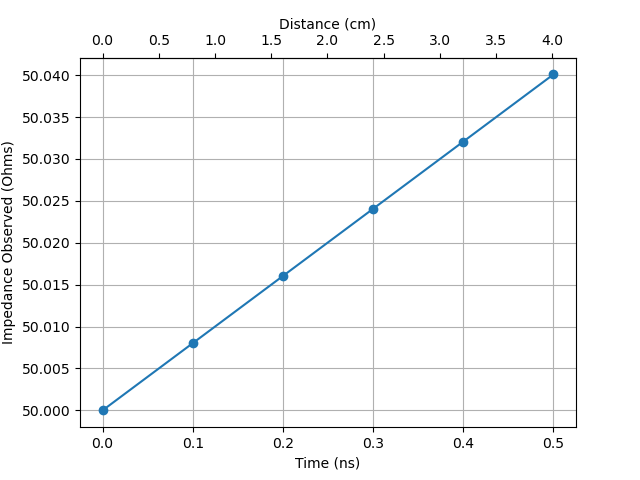

In [11]:
x = np.array([1, 
  G,
  G*T**2,
  G**3 * T**2 + G * T**4,
  2*G**5 * T**2 + 4*G**3 * T**4 + G*T**6,
  3*G**7 * T**2 + 11*G**5 * T**4 + 7*G**3 * T**6 + G*T**8])

y = [x[0]]
for nn in range(1,len(x)):
  y.append(x[nn] + y[-1])

print(x)
print(y)

fig, ax = plt.subplots(1,1)
t = 2*td*np.arange(0, len(y))
z = v2z(y, Zo, Vplus)
ax.plot(t*1e9, z, marker='o')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Impedance Observed (Ohms)')
ax.grid(True)

dist_ax = ax.secondary_xaxis('top', functions=(t2l,l2t))
dist_ax.set_xlabel('Distance (cm)')

# Track Only the First Reflection (No Multiple Reflections)

The bounce diagram below is tracking a single multiple reflection, which leaves the response with terms with $\Gamma$ and also with a $\Gamma^3$ term.  The plot below only reflects the single cases.  $\Gamma$ is very small, which makes terms with multiple reflections insignificant.

<img src="figs/One_Bounce_Diagram_Rs.png" alt="Bounce Full" width="50%"/>

Text(0.5, 0, 'Distance (cm)')

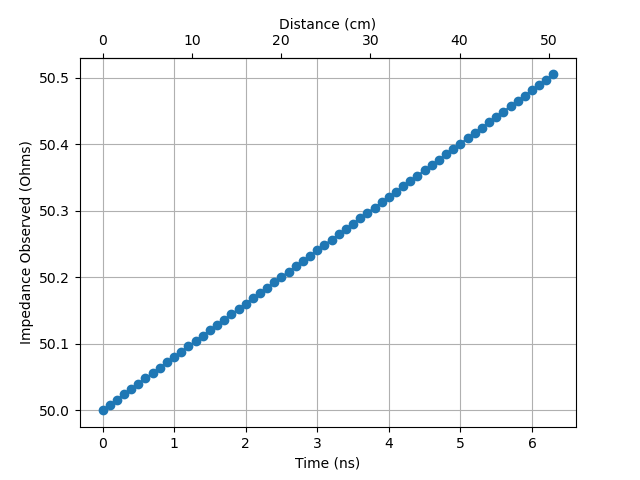

In [12]:
NN = np.ceil(Ltot/(lx))
nn = np.arange(0, NN)
x = G * T**(2*nn)
y = [1, ]
for xi in x:
  y.append(xi + y[-1])

fig, ax = plt.subplots(1,1)
t = 2*td*np.arange(0, len(y))
z = v2z(y, Zo, Vplus)
ax.plot(t*1e9, z, marker='o')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Impedance Observed (Ohms)')
ax.grid(True)

dist_ax = ax.secondary_xaxis('top', functions=(t2l,l2t))
dist_ax.set_xlabel('Distance (cm)')

# Track the First, Second, and Third Order Reflections

Use waves that have been reflected once $\left(\Gamma\right)$ and some multiple reflection bounce $\left(\Gamma^3\ \text{and}\ \Gamma^5 \text{terms}\right)$.  Unless both the resistance and the step size is set relatively large, the responses with multiple reflections will be indistinguishable from the response including only the first reflection.

[8.01719445e-05 8.01590900e-05 8.01462374e-05 8.01333870e-05
 8.01205386e-05 8.01076923e-05 8.00948480e-05 8.00820058e-05]
[0, 0, 0, 5.1522581215687e-13, 5.151432021580522e-13, 5.150606054047119e-13, 5.149780218947254e-13, 5.148954516259693e-13]
[0, 0, 0, 0, 0, 3.3116348710160504e-21, 3.3111038918874346e-21, 3.310572997894664e-21]


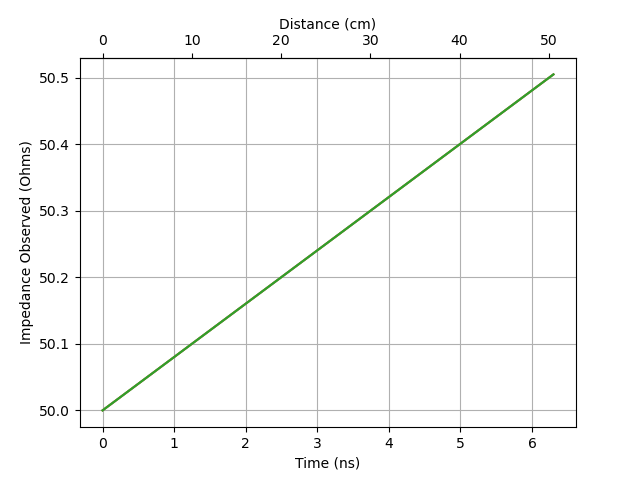

In [13]:
NN = np.ceil(Ltot/(lx))
nn = np.arange(0, NN)

x = G * T**(2*nn)
x3 = [G**3 * T**(2*(ni - 2)) if ni > 2 else 0 for ni in nn]
x5 = [G**5 * T**(2*(ni - 4)) if ni > 4 else 0 for ni in nn]

y = [1, ]
y3 = [1, ]
y5 = [1, ]
for xi, x3i, x5i in zip(x, x3, x5):
  y.append(xi + y[-1])
  y3.append(xi + x3i + y3[-1])
  y5.append(xi + x3i + x5i + y5[-1])

#print(x)
#print(x3)
#print(y)

fig, ax = plt.subplots(1,1)
t = 2*td*np.arange(0, len(y))
z = v2z(y, Zo, Vplus)
z3 = v2z(y3, Zo, Vplus)
z5 = v2z(y5, Zo, Vplus)
ax.plot(t*1e9, z)
ax.plot(t*1e9, z3)
ax.plot(t*1e9, z5)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Impedance Observed (Ohms)')
ax.grid(True)

dist_ax = ax.secondary_xaxis('top', functions=(t2l,l2t))
dist_ax.set_xlabel('Distance (cm)')

print(x[:8])
print(x3[:8])
print(x5[:8])
